# Distribution
Modeling the distribution of game playout scores


The starting board:
```
[[128.  32.  16.   8.]
 [  2.  16.   8.   2.]
 [ 32.   4.   2.    .]
 [   .   2.    .   2.]]
 ```
 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
dist = np.load('dist.npz')


In [2]:
results = np.asarray([dist['left'],
                      dist['up'],
                      dist['right'],
                      dist['down']])
results.sort(axis=1)
logresults = np.log10(results)
print(results.mean(axis=1))


[1508.3   1564.908 1530.568  687.28 ]


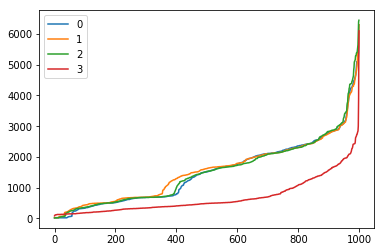

In [8]:
for i in range(4):
    plt.plot(results[i])
plt.legend(list(range(4)))

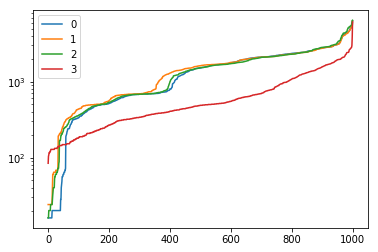

In [9]:
for i in range(4):
    plt.semilogy(results[i])
plt.legend(list(range(4)))

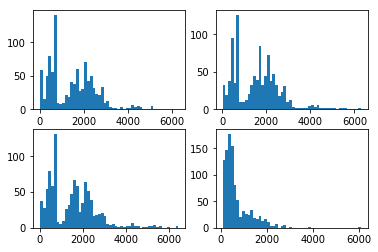

In [18]:
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist(results[i], bins=50);


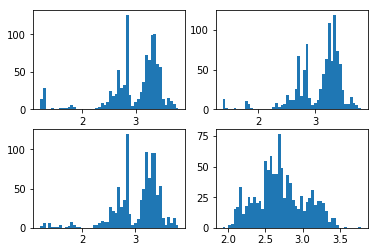

In [19]:
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist(logresults[i]), bins=50);


Like I found before, the log-distribution sometimes follows a Weibull distribution, as in the 4th histogram. However, there can be certain 'barriers' that only allow a portion of lines to pass. These distributions are clearly not classical.


### Tests:
* The Kullback-Leibler Divergence is used for continuous distributions.
* The Kolmogorov-Smirnov Metric is used for discrete distributions.


In [3]:
kstest = np.zeros((2, 4, 4)) * np.nan
for i in range(3):
    for j in range(3-i):
        D, p = stats.ks_2samp(logresults[i], logresults[i+j+1])
        kstest[0, i, i+j+1] = D
        kstest[1, i, i+j+1] = p
        print('{0}:{1}    {2:.3f}, {3:.3f}'.format(i, i+j+1, D, p))
    

0:1    0.056, 0.084
0:2    0.033, 0.641
0:3    0.411, 0.000
1:2    0.045, 0.258
1:3    0.452, 0.000
2:3    0.421, 0.000


In [6]:
np.set_printoptions(precision=2)
print(kstest)

[[[     nan 5.60e-02 3.30e-02 4.11e-01]
  [     nan      nan 4.50e-02 4.52e-01]
  [     nan      nan      nan 4.21e-01]
  [     nan      nan      nan      nan]]

 [[     nan 8.39e-02 6.41e-01 1.31e-74]
  [     nan      nan 2.58e-01 3.79e-90]
  [     nan      nan      nan 2.91e-78]
  [     nan      nan      nan      nan]]]


## Statistics
How many samples do I need to draw from this distribution to maintain statistical separation?

#### Large difference
Move 1 vs Move 3 has a KS statistic of 0.45 (p=0).

For large differences, even 5 samples is enough to get 95% accuracy. 10 samples gives more than 99%. 

Using log scores gives poorer accuracy.

| Samples | p_Correct | p_cor log |
| ------- | --------- | --------- |
| 5 | 0.9571 | 0.9294 |
| 10 | 0.9923 | 0.9741 |
| 20 | 0.9996 | 0.9975 |

In [20]:
samples = 10
times = 10000
correct = 0
for i in range(times):
    one = np.mean(np.random.choice(results[1], samples))
    two = np.mean(np.random.choice(results[3], samples))
    if one > two:
        correct += 1
print(correct / times)

0.993


In [23]:
samples = 20
times = 10000
correct = 0
for i in range(times):
    one = np.mean(np.random.choice(logresults[1], samples))
    two = np.mean(np.random.choice(logresults[3], samples))
    if one > two:
        correct += 1
print(correct / times)

0.9975


#### Medium difference
Move 0 vs Move 1 has a KS statistic of 0.056 (p=0.084)

With these finer differences, it is much harder to be accurate with small samples. 100 samples gives only 64% or 83% with log. Will need more than 200 samples to get better than 90% accuracy.

Log scores now give much better ability to discern theses small differences.

| Samples | p_Correct | p_cor log |
| ------- | --------- | --------- |
| 10 | 0.5524 | 0.6124 |
| 20 | 0.5741 | 0.6605 |
| 50 | 0.6063 | 0.7417 |
| 100 | 0.6461 | 0.8284 |
| 200 | 0.7050 | 0.9120 |
| 500 | 0.8025 | 0.9858 |

Sample size >500 is approaching the pool size of 1000, so result may not be entirely correct w.r.t. underlying distribution.

In [35]:
samples = 500
times = 10000
correct = 0
for i in range(times):
    one = np.mean(np.random.choice(results[1], samples))
    two = np.mean(np.random.choice(results[0], samples))
    if one > two:
        correct += 1
print(correct / times)

correct = 0
for i in range(times):    
    one = np.mean(np.random.choice(logresults[1], samples))
    two = np.mean(np.random.choice(logresults[0], samples))
    if one > two:
        correct += 1
print(correct / times)

0.8025
0.9858


#### Small difference
Move 0 vs Move 2 has a KS statistic of 0.033 (p=0.64)

Extremely small differences are difficult to pick up. Here, the log value helps a lot. 70% at 100 samples is very good given that these two distributions are nearly identical (a few more lines die early in move 0 than in move 2).

| Samples | p_Correct | p_cor log |
| ------- | --------- | --------- |
| 20 | 0.5294 | 0.5866 |
| 50 | 0.5413 | 0.6357 |
| 100 | 0.5613 | 0.6955 |
| 200 | 0.5776 | 0.7605 |
| 500 | 0.6243 | 0.8582 |
| 750 | 0.6533 | 0.9212 |

Sample size >500 is approaching the pool size of 1000, so result may not be entirely correct w.r.t. underlying distribution.

In [43]:
samples = 10
times = 10000
correct = 0
for i in range(times):
    one = np.mean(np.random.choice(results[2], samples))
    two = np.mean(np.random.choice(results[0], samples))
    if one > two:
        correct += 1
print(correct / times)

correct = 0
for i in range(times):    
    one = np.mean(np.random.choice(logresults[2], samples))
    two = np.mean(np.random.choice(logresults[0], samples))
    if one > two:
        correct += 1
print(correct / times)

0.5187
0.5595


#### Choice
Final choice for number of lines: 50, with log scores

With 50 lines per move, you get near perfect discrimination of large differences, 74% (a decent chance) for medium differences, and 64% (better than random) for small differences.

These percentages should get better as the network learns to play better games.